In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path

import os
import glob
import re
import sys

from ipywidgets import interact, Dropdown

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm

home_directory = "/d/ret1/Taylor/jupyter_notebooks/Research" 
parent_dir = Path(home_directory).resolve() #TJ current notebook's parent directory
os.chdir(parent_dir) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import * #TJ import basic functions from custom package
from Py_files.Image_vs_spectra import *
from Py_files.Convolution_script import *

#IFU_files = glob.glob('Data_files/IFU_files/*s3d.fits') #TJ this is not correctly sorted, run this and copy into line below
IFU_files = [ 'Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits',
             'Data_files/IFU_files/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
             'Data_files/IFU_files/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
             'Data_files/IFU_files/SW_IFU_ch1-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/SW_IFU_ch2-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/SW_IFU_ch3-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d.fits',
            ]
image_files, filter_files = generate_list_of_files()
filter_names = ['F115W', 'F140M', 'F150W', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F300M', 'F335M', 'F360M', 'F405N', 
           'F430M', 'F444W', 'F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W'] 


True
/d/ret1/Taylor/stpsf-data/


In [15]:
def which_fits(filter_file, list_of_fits):
    '''open the filter file, determine the range of wavelengths needed to compute synthetic flux through it, return which fits files
    are needed for this particular filter. This is to save time not convolving cubes we dont need.
    -------------
    
    Parameters
    -------------
    filter_file : type = str - string to location of filter file that we are interested in.
    list_of_fits : type = list - list of strings to the IFU fits files that you want to check
    
    Returns
    -------------
    needed_fits : type = list - list of strings to the fits files that are actually needed
    '''   
    filter_data = []
    with open(filter_file, 'r') as f:
            header = f.readline().strip().split()
            for line in f:
                data_line = line.strip().split()
                filter_data.append(data_line)
            
    header, filter_T = filter_data[:2], np.array(filter_data[2:])

    wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    T = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
    
    min_wl, max_wl = min(wl), max(wl)
    needed_fits = []
    for file in list_of_fits:
        cube = SpectralCube.read(file, hdu='SCI')
        wavelength = cube.spectral_axis
        if (wavelength[0].value*1e-6 < max_wl) and (wavelength[-1].value*1e-6 > min_wl):
            needed_fits.append(file)
    return needed_fits



loc = [202.4340450, 47.1732517] 
radius = 0.75*u.arcsec
def combine_spectra(first, next, loc, radius, show_plot = False):
    '''extract the spectrum from a region specified by loc and radius from each IFU file, then stitch them together
    This function subtracts the next spectrum from the first spectrum in the overlapping region, takes the median of the
    difference, then adds that difference to the next spectrum to get the new values. overlapping region is overwritten
    by the corrected next spectrum.
    -------------
    
    Parameters
    -------------
    first : type = str - string to location of IFU fits with shorter wavelength of the two
                ****This can also be an already combined spectrum for iterative stitching
    next : type = str - string to the location of the IFU fits file with the longer wavelengths (should have an overlap)
    loc : type = list - ra, dec in degrees or SkyCoord object
    radius : type = float - radius of aperture with units
    show_plot (optional, defaults to False) : type = boolean - show plot of the stitched spectrum?
    
    Returns
    -------------
    combined spectrum : dictionary has entries for ['wavelength'] and ['intensity'] which span the full range of the two files
    '''   

    if type(first) == str:
        
        first_IFU_hdul = fits.open(first)
        first_header = first_IFU_hdul["SCI"].header
        first_cube = SpectralCube.read(first, hdu='SCI')
        first_wcs = WCS(first_header)
        first_spectral_axis = first_cube.spectral_axis
        first_spectrum = get_IFU_spectrum(first, loc, radius, replace_negatives = 1e-1)
    elif type(first) == dict:
        first_spectrum = first
    else:
        print('first argument was not a dictionary or a string to a file')
    next_IFU_hdul = fits.open(next)
    next_header = next_IFU_hdul["SCI"].header
    next_cube = SpectralCube.read(next, hdu='SCI')
    next_wcs = WCS(next_header)
    next_spectral_axis = next_cube.spectral_axis
    next_spectrum = get_IFU_spectrum(next, loc, radius, replace_negatives = 1e-1)
    mask_first = (first_spectrum['wavelength'] >= next_spectrum['wavelength'][0])
    mask_next = (next_spectrum['wavelength'] <= first_spectrum['wavelength'][-1])
    next_interp = np.interp(first_spectrum['wavelength'][mask_first], next_spectrum['wavelength'][mask_next], next_spectrum['intensity'][mask_next])
    diff_spectrum = first_spectrum['intensity'][mask_first] - next_interp
    median_diff = np.nanmedian(diff_spectrum)
    corrected_next = next_spectrum['intensity'] + median_diff
    combined_spectrum = {
    'wavelength': np.concatenate([first_spectrum['wavelength'][~mask_first], next_spectrum['wavelength']]),
    'intensity': np.concatenate([first_spectrum['intensity'][~mask_first], corrected_next])
    }
    if show_plot:
        
        plt.plot(combined_spectrum['wavelength'], combined_spectrum['intensity'], color = 'red', label = 'combined')
        plt.plot(next_spectrum['wavelength'], next_spectrum['intensity'], color = 'orange', label = 'raw')
        plt.yscale('log')
        plt.legend()
        plt.show()
        
    return combined_spectrum

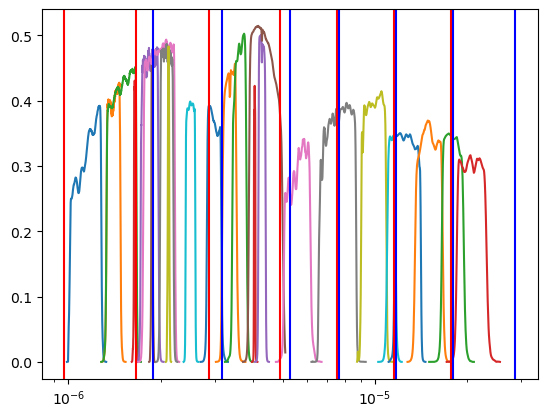

In [28]:
for file in filter_files:
    filter_data = []
    with open(file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
            
        header, filter_T = filter_data[:2], np.array(filter_data[2:])
        filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
        filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
    plt.plot(filter_wl,filter_trans)
[plt.axvline(x=i, color = 'red') for i in starts]
[plt.axvline(x=i, color = 'blue') for i in ends]
plt.xscale('log')

In [3]:
image_flux = []
IFU_flux = []
for file in filter_files:
    needed_fits = which_fits(file, IFU_files)
    print(f'for filter {extract_filter_name(file).upper()} we need: {needed_fits}')
    current_filter_name = extract_filter_name(file).upper()
    image_file = [img for img in image_files if extract_filter_name(img).upper() == current_filter_name][0]
    print(f'image file selected as {image_file}')
    new_fits = []
    for IFU_file in needed_fits:
        instrument = 'NIRCam' if 'nirspec' in IFU_file else "MIRI"
        new_fits.append(convolve(IFU_file, instrument, extract_filter_name(file).upper(), output_file = f'{IFU_file.split("-")[-1].split(".f")[0]}IFU_convolved_to{extract_filter_name(file)}.fits'))
    if len(needed_fits) > 1:
        spectrum = combine_spectra(new_fits[0], new_fits[1], loc, radius, show_plot = False)
    else:
        spectrum = get_IFU_spectrum(new_fits[0], loc, radius, replace_negatives = 1e-1)
    aperture_area_sr = np.pi * (radius.to(u.rad))**2
    filter_data = []
    with open(file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
            
    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
    
    print('IFU', spectrum["wavelength"][0], spectrum["wavelength"][-1])
    print('filter', filter_wl[0], filter_wl[-1])
    
    IFU_expected_flux = ((get_Fnu_transmission(spectrum["intensity"], spectrum["wavelength"], filter_trans, filter_wl)))
    photo_flux = (get_image_flux(image_file, loc, radius))
    IFU_flux.append(IFU_expected_flux)
    image_flux.append(photo_flux)
IFU_flux = np.array(IFU_flux)
image_flux = np.array(image_flux)
plt.style.use('seaborn-v0_8-paper')  #TJ just a random style for the plot

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12}) #TJ 
# Now plot with sorted data
plt.figure(figsize=(10, 6))
plt.scatter([extract_filter_name(x) for x in filter_files], IFU_flux/image_flux, label='IFU-determined', s=100, marker='x', color='red')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='y', which='both', labelsize=10)
plt.legend()
plt.xlabel('Filter Names')
plt.ylabel('Filter Pass Through (MJy)')
plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to Spectrum-derived values")
plt.tight_layout()
plt.show()

for filter F115W we need: ['Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f115w_i2d.fits


Convolving to F115W:   0%|          | 0/1447 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as f100lp_s3dIFU_convolved_tof115w.fits
IFU 9.703180286160204e-07 1.8899740453634867e-06
filter 9.892e-07 1.3282e-06
for filter F140M we need: ['Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f140m_i2d.fits


Convolving to F140M:   0%|          | 0/1447 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as f100lp_s3dIFU_convolved_tof140m.fits
IFU 9.703180286160204e-07 1.8899740453634867e-06
filter 1.28235e-06 1.5363500000000001e-06
for filter F150W we need: ['Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits', 'Data_files/IFU_files/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f150w_i2d.fits


Convolving to F150W:   0%|          | 0/1447 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as f100lp_s3dIFU_convolved_tof150w.fits


Convolving to F150W:   0%|          | 0/1425 [00:00<?, ?it/s]

RuntimeError: The requested wavelengths are too long for NIRCam short wave channel.

In [ ]:
def combine_spectra(first, next, loc, radius, show_plot = False):
    '''extract the spectrum from a region specified by loc and radius from each IFU file, then stitch them together
    This function subtracts the next spectrum from the first spectrum in the overlapping region, takes the median of the
    difference, then adds that difference to the next spectrum to get the new values. overlapping region is overwritten
    by the corrected next spectrum.
    -------------
    
    Parameters
    -------------
    first : type = str - string to location of IFU fits with shorter wavelength of the two
                ****This can also be an already combined spectrum for iterative stitching
    next : type = str - string to the location of the IFU fits file with the longer wavelengths (should have an overlap)
    loc : type = list - ra, dec in degrees or SkyCoord object
    radius : type = float - radius of aperture with units
    show_plot (optional, defaults to False) : type = boolean - show plot of the stitched spectrum?
    
    Returns
    -------------
    combined spectrum : dictionary has entries for ['wavelength'] and ['intensity'] which span the full range of the two files
    '''   

    if type(first) == str:
        
        first_IFU_hdul = fits.open(first)
        first_header = first_IFU_hdul["SCI"].header
        first_cube = SpectralCube.read(first, hdu='SCI')
        first_wcs = WCS(first_header)
        first_spectral_axis = first_cube.spectral_axis
        first_spectrum = get_IFU_spectrum(first, loc, radius, replace_negatives = 1e-1)
    elif type(first) == dict:
        first_spectrum = first
    else:
        print('first argument was not a dictionary or a string to a file')
    next_IFU_hdul = fits.open(next)
    next_header = next_IFU_hdul["SCI"].header
    next_cube = SpectralCube.read(next, hdu='SCI')
    next_wcs = WCS(next_header)
    next_spectral_axis = next_cube.spectral_axis
    next_spectrum = get_IFU_spectrum(next, loc, radius, replace_negatives = 1e-1)

    
    mask_first = (first_spectrum['wavelength'] >= next_spectrum['wavelength'][0])
    mask_next = (next_spectrum['wavelength'] <= first_spectrum['wavelength'][-1])

    
    first_interp = np.interp(next_spectrum['wavelength'][mask_next], first_spectrum['wavelength'][mask_first], first_spectrum['intensity'][mask_first])
    diff_spectrum = next_spectrum['intensity'][mask_next] - first_interp
    median_diff = np.nanmedian(diff_spectrum)
    corrected_first = first_spectrum['intensity'] + median_diff
    
    combined_spectrum = {
    'wavelength': np.concatenate([first_spectrum['wavelength'], next_spectrum['wavelength'][~mask_next]]),
    'intensity': np.concatenate([corrected_first, next_spectrum['intensity'][~mask_next]])
    }
    if show_plot:
        
        plt.plot(combined_spectrum['wavelength'], combined_spectrum['intensity'], color = 'red', label = 'combined')
        plt.plot(next_spectrum['wavelength'], next_spectrum['intensity'], color = 'orange', label = 'raw')
        plt.yscale('log')
        plt.legend()
        plt.show()
        
    return combined_spectrum

In [ ]:
files = ['Data_files/IFU_files/SW_IFU_ch1-shortmediumlong_s3d.fits', 'Data_files/IFU_files/SW_IFU_ch2-shortmediumlong_s3d.fits', 
         'Data_files/IFU_files/SW_IFU_ch3-shortmediumlong_s3d.fits', 'Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d.fits']
loc = [202.4340450, 47.1732517] 
radius = 0.75*u.arcsec
data = []
for i, file in enumerate(files):
    IFU_hdul = fits.open(file)
    header = IFU_hdul["SCI"].header
    cube = SpectralCube.read(file, hdu='SCI')
    wcs = WCS(header)

    spectral_axis = cube.spectral_axis
    data.append(get_IFU_spectrum_test(file, loc, radius))
    
first_end = len(data[0]['wavelength'][data[0]['wavelength'] > data[1]['wavelength'][0]])
second_start = len(data[1]['wavelength'][data[1]['wavelength'] < data[0]['wavelength'][-1]])
second_end = len(data[1]['wavelength'][data[1]['wavelength'] > data[2]['wavelength'][0]])
third_start = len(data[2]['wavelength'][data[2]['wavelength'] < data[1]['wavelength'][-1]])
third_end = len(data[2]['wavelength'][data[2]['wavelength'] > data[3]['wavelength'][0]])
fourth_start = len(data[3]['wavelength'][data[3]['wavelength'] < data[2]['wavelength'][-1]])

In [ ]:

plt.plot(data[0]['wavelength'][-2*first_end:], data[0]['intensity'][-2*first_end:], color = 'blue', label = 'data1')
plt.plot(data[1]['wavelength'][:2*second_start], data[1]['intensity'][:2*second_start], color = 'orange', label = 'data2')
plt.show()
plt.plot(data[1]['wavelength'][-2*second_end:]*1e+6, data[1]['intensity'][-2*second_end:], color = 'blue', label = 'channel 2')
plt.plot(data[2]['wavelength'][:2*third_start]*1e+6, data[2]['intensity'][:2*third_start], color = 'orange', label = 'channel 3')
plt.xlabel('wavelength (microns)')
plt.ylabel('intensity')
plt.title('MIRI Channels 2 and 3 overlapping region')
plt.legend()
plt.show()
plt.plot(data[2]['wavelength'][-2*third_end:]*1e+6, data[2]['intensity'][-2*third_end:], color = 'orange', label = 'channel 3')
plt.plot(data[3]['wavelength'][:2*fourth_start]*1e+6, data[3]['intensity'][:2*fourth_start], color = 'green', label = 'channel 4')
plt.xlabel('wavelength (microns)')
plt.ylabel('intensity')
plt.title('MIRI Channels 3 and 4 overlapping region')
plt.legend()
plt.show()

In [ ]:
plt.plot(data[3]['wavelength'], data[3]['intensity'], color = 'green', label = 'channel 4')
plt.xlabel('wavelength (microns)')
plt.ylabel('intensity')
plt.title('Channels 3 and 4 overlapping region')
plt.legend()
plt.show()

In [ ]:



from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from spectral_cube import SpectralCube

def find_point_spectrum(IFU_filepath, loc):
    '''extract the pixel spectrum with bilinear interpolation for a location in ra,dec
    -------------
    
    Parameters
    -------------
    IFU_filepath : type = str - string to location of IFU fits file
    loc : type = list - ra, dec in degrees or SkyCoord object
    
    Returns
    -------------
    SpectralCube slice corresponding to the interpolated spectrum
    '''   
    hdul = fits.open(IFU_filepath)
    header = hdul['SCI'].header
    wcs = WCS(header)
    cube = SpectralCube.read(IFU_filepath, hdu='SCI')

    # === CONVERT RA/DEC TO PIXEL COORDINATES ===
    # Create SkyCoord object for spatial coordinates
    if type(loc) == list:
        spatial_coords = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg)
    elif type(loc) == SkyCoord:
        spatial_coords = loc
    else:
        print('loc is not a list of ra, dec and it is not a SkyCoord object.')
        return None
    
    # Convert spatial coordinates to pixels
    x, y = wcs.celestial.all_world2pix(spatial_coords.ra.deg, 
                                      spatial_coords.dec.deg, 0)
    
    # Get integer and fractional parts
    x_int, y_int = int(np.floor(x)), int(np.floor(y))
    x_frac, y_frac = x - x_int, y - y_int
    
    # Ensure we don't go out of bounds
    x_max = cube.shape[2] - 1
    y_max = cube.shape[1] - 1
    
    x0 = max(0, min(x_int, x_max))
    x1 = max(0, min(x_int + 1, x_max))
    y0 = max(0, min(y_int, y_max))
    y1 = max(0, min(y_int + 1, y_max))
    
    # Get the four surrounding spectra
    spec00 = cube[:, y0, x0]
    spec01 = cube[:, y0, x1]
    spec10 = cube[:, y1, x0]
    spec11 = cube[:, y1, x1]
    
    # Perform bilinear interpolation
    interpolated_spectrum = (spec00 * (1 - x_frac) * (1 - y_frac) +
                            spec01 * x_frac * (1 - y_frac) +
                            spec10 * (1 - x_frac) * y_frac +
                            spec11 * x_frac * y_frac)
    
    return interpolated_spectrum

In [ ]:

spectrum = find_point_spectrum(files[0], loc)
wavelengths = spectrum.spectral_axis
plt.plot(wavelengths[-2*first_end:], spectrum[-2*first_end:], color = 'red', label = 'channel 1')

spectrum = find_point_spectrum(files[1], loc)
wavelengths = spectrum.spectral_axis

plt.plot(wavelengths[:2*second_start], spectrum[:2*second_start], color = 'orange', label = 'channel 2')
plt.legend()
plt.show()

############################
spectrum = find_point_spectrum(files[1], loc)
wavelengths = spectrum.spectral_axis
plt.plot(wavelengths[-2*second_end:], spectrum[-2*second_end:], color = 'orange', label = 'channel 2')

spectrum = find_point_spectrum(files[2], loc)
wavelengths = spectrum.spectral_axis
plt.plot(wavelengths[:2*third_start], spectrum[:2*third_start], color = 'green', label = 'channel 3')
plt.legend()
plt.show()

#######################
spectrum = find_point_spectrum(files[2], loc)
wavelengths = spectrum.spectral_axis
plt.plot(wavelengths[-2*third_end:], spectrum[-2*third_end:], color = 'green', label = 'channel 3')

spectrum = find_point_spectrum(files[3], loc)
wavelengths = spectrum.spectral_axis
plt.plot(wavelengths[:2*fourth_start], spectrum[:2*fourth_start], color = 'blue', label = 'channel 4')
plt.legend()
plt.show()

In [25]:
starts = []
ends = []
for i,file in enumerate(IFU_files):
    cube = SpectralCube.read(file, hdu='SCI')
    starts.append(cube.spectral_axis[0].value*1e-6)
    ends.append(cube.spectral_axis[-1].value*1e-6)
    

In [ ]:
plt.plot(combined_spectrum['wavelength'], combined_spectrum['intensity'])

In [17]:
radius

<Quantity 0.75 arcsec>